## Unzipping Files

In [1]:
import zipfile
import os

# Path to the zip file
zip_path = "Medical Imagining (CT scan, MRI, X-ray, and Microscopic Imagery) Data.zip"
# Directory to extract to
extract_dir = "Medical_Imaging_Data"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to '{extract_dir}'")

Files extracted to 'Medical_Imaging_Data'


## Dataset Preparation

In [4]:
import os
import json
import shutil

# Paths
base_dir = "/Volumes/Sarbajit/Model Optimization/Data/ISIC/data/"
metadata_file = "/Volumes/Sarbajit/Model Optimization/Data/ISIC/data/metadata.jsonl"
output_dir = os.path.join(base_dir, "labeled")

# Class mapping
class_names = {
    "0": "Melanoma",
    "1": "Melanocytic_nevus",
    "2": "Basal_cell_carcinoma",
    "3": "Actinic_keratosis",
    "4": "Benign_keratosis",
    "5": "Dermatofibroma",
    "6": "Vascular_lesion",
    "7": "Squamous_cell_carcinoma",
    "8": "None_of_the_others"
}

# Create class folders
for label, name in class_names.items():
    os.makedirs(os.path.join(output_dir, f"{label}_{name}"), exist_ok=True)

# Process metadata.jsonl
with open(metadata_file, "r") as f:
    for line in f:
        record = json.loads(line.strip())
        file_name = record["file_name"]
        label = str(record["label"])

        # Full source path
        src = os.path.join(base_dir, file_name)

        # Destination folder
        dst_folder = os.path.join(output_dir, f"{label}_{class_names[label]}")
        dst = os.path.join(dst_folder, os.path.basename(file_name))

        # Move image (change to shutil.copy if you prefer copy)
        if os.path.exists(src):
            shutil.move(src, dst)
        else:
            print(f"⚠️ Missing file: {src}")

print("✅ Images organized into class folders:", output_dir)


✅ Images organized into class folders: /Volumes/Sarbajit/Model Optimization/Data/ISIC/data/labeled


In [1]:
import os
import shutil

# Base path
base_path = "/Volumes/Sarbajit/Model Optimization/Data/chest_xray"

# Source subfolders
subfolders = ["train", "test", "val"]

# Destination folders
final_normal = os.path.join(base_path, "Final_Normal")
final_pneumonia = os.path.join(base_path, "Final_Pneumonia")

# Create destination folders if they don't exist
os.makedirs(final_normal, exist_ok=True)
os.makedirs(final_pneumonia, exist_ok=True)

# Loop through each subfolder (train, test, val)
for sub in subfolders:
    for cls in ["NORMAL", "PNEUMONIA"]:
        src_folder = os.path.join(base_path, sub, cls)
        if not os.path.exists(src_folder):
            continue
        
        # Select target destination
        if cls.lower() == "normal":
            dest_folder = final_normal
        else:
            dest_folder = final_pneumonia
        
        # Copy all files
        for filename in os.listdir(src_folder):
            src_file = os.path.join(src_folder, filename)
            if os.path.isfile(src_file):
                shutil.copy2(src_file, dest_folder)

print("✅ All files have been copied successfully!")
print(f"Final Normal folder: {final_normal}")
print(f"Final Pneumonia folder: {final_pneumonia}")


✅ All files have been copied successfully!
Final Normal folder: /Volumes/Sarbajit/Model Optimization/Data/chest_xray/Final_Normal
Final Pneumonia folder: /Volumes/Sarbajit/Model Optimization/Data/chest_xray/Final_Pneumonia


In [2]:
import os

base_path = "/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Data"

# Walk through all subdirectories and count files
for root, dirs, files in os.walk(base_path):
    # Count only image files (you can adjust extensions if needed)
    image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        print(f"{root}: {len(image_files)} images")


/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Data/Pneumonia: 4273 images
/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Data/Normal: 1583 images


In [3]:
import os
import random
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# ------------------------------
# PATH CONFIGURATION
# ------------------------------
base_path = "/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Data"
output_path = "/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Final_Balanced_Dataset"

normal_dir = os.path.join(base_path, "Normal")
pneumonia_dir = os.path.join(base_path, "Pneumonia")

final_normal_dir = os.path.join(output_path, "Normal")
final_pneumonia_dir = os.path.join(output_path, "Pneumonia")

os.makedirs(final_normal_dir, exist_ok=True)
os.makedirs(final_pneumonia_dir, exist_ok=True)

# ------------------------------
# COUNT ORIGINAL IMAGES
# ------------------------------
normal_images = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
pneumonia_images = [os.path.join(pneumonia_dir, f) for f in os.listdir(pneumonia_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

n_normal = len(normal_images)
n_pneumonia = len(pneumonia_images)

print(f"Original Normal: {n_normal}, Pneumonia: {n_pneumonia}")

# ------------------------------
# AUGMENTATION SETUP
# ------------------------------
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

resize = transforms.Resize((224, 224))

# ------------------------------
# COPY ORIGINAL IMAGES
# ------------------------------
print("\nCopying original images...")
for img_path in tqdm(normal_images):
    img = Image.open(img_path).convert("RGB")
    img = resize(img)
    img.save(os.path.join(final_normal_dir, os.path.basename(img_path)))

for img_path in tqdm(pneumonia_images):
    img = Image.open(img_path).convert("RGB")
    img = resize(img)
    img.save(os.path.join(final_pneumonia_dir, os.path.basename(img_path)))

# ------------------------------
# AUGMENT TO BALANCE
# ------------------------------
print("\nAugmenting Normal class to balance dataset...")

target_count = n_pneumonia  # match pneumonia count
extra_needed = target_count - n_normal
if extra_needed <= 0:
    print("Dataset already balanced.")
else:
    for i in tqdm(range(extra_needed)):
        src_img_path = random.choice(normal_images)
        img = Image.open(src_img_path).convert("RGB")
        img = augmentations(img)
        new_name = f"aug_{i}_{os.path.basename(src_img_path)}"
        img.save(os.path.join(final_normal_dir, new_name))

# ------------------------------
# FINAL REPORT
# ------------------------------
final_normal_count = len(os.listdir(final_normal_dir))
final_pneumonia_count = len(os.listdir(final_pneumonia_dir))

print("\n✅ Final dataset created successfully!")
print(f"Final Normal: {final_normal_count} images")
print(f"Final Pneumonia: {final_pneumonia_count} images")
print(f"Saved in: {output_path}")


Original Normal: 1583, Pneumonia: 4273

Copying original images...


100%|██████████| 4273/4273 [00:14<00:00, 291.59it/s]



Augmenting Normal class to balance dataset...


100%|██████████| 2690/2690 [00:41<00:00, 65.39it/s]


✅ Final dataset created successfully!
Final Normal: 4273 images
Final Pneumonia: 4273 images
Saved in: /Volumes/Sarbajit/Model Optimization/Data/chest_xray/Final_Balanced_Dataset


In [4]:
import os
from PIL import Image
from tqdm import tqdm

# Path to your balanced dataset
base_path = "/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Final_Balanced_Dataset"

# Define resize transformation
target_size = (224, 224)

# Go through each class folder
for cls in ["Normal", "Pneumonia"]:
    folder_path = os.path.join(base_path, cls)
    if not os.path.exists(folder_path):
        continue

    print(f"\nResizing images in {cls} folder...")
    for filename in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path).convert("RGB") as img:
                img = img.resize(target_size)
                img.save(file_path)  # overwrite the same file
        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

print("\n✅ All images resized to 224×224 successfully and replaced in place!")



Resizing images in Normal folder...


100%|██████████| 4273/4273 [00:01<00:00, 3004.33it/s]



Resizing images in Pneumonia folder...


100%|██████████| 4273/4273 [00:01<00:00, 3147.64it/s]


✅ All images resized to 224×224 successfully and replaced in place!


## Model Training

**Chest Xray**

In [11]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/chest_xray/Final_Balanced_Dataset"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/ChestXray"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-05 20:42:20.508570: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-05 20:42:20.508598: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-05 20:42:20.508603: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-05 20:42:20.508616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-05 20:42:20.508626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 5982 validated image filenames belonging to 2 classes.
Found 1282 validated image filenames belonging to 2 classes.
Found 1282 valid

## SKIN LESION

In [4]:
import os
from PIL import Image
from tqdm import tqdm

# =========================================================
# Path to your dataset
# =========================================================
base_path = "/Volumes/Sarbajit/Model Optimization/Data/Skin Leison"
target_size = (224, 224)

# =========================================================
# Automatically detect all class folders
# =========================================================
class_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(f"🔍 Found class folders: {class_folders}")

# =========================================================
# Resize all .jpg images in each class folder
# =========================================================
for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    print(f"\n📁 Resizing images in '{cls}' folder...")

    jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]

    for filename in tqdm(jpg_files, desc=f"Processing {cls}", ncols=80):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path).convert("RGB") as img:
                img = img.resize(target_size, Image.LANCZOS)
                img.save(file_path, "JPEG", quality=95)
        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

print("\n✅ All .jpg images resized to 224×224 successfully across all 8 classes!")


🔍 Found class folders: ['DF', 'AK', 'BKL', 'VASC', 'NV', 'BCC', 'SCC', 'MEL']

📁 Resizing images in 'DF' folder...


Processing DF: 100%|█████████████████████████| 184/184 [00:01<00:00, 157.89it/s]



📁 Resizing images in 'AK' folder...


Processing AK: 100%|██████████████████████████| 211/211 [00:02<00:00, 79.31it/s]



📁 Resizing images in 'BKL' folder...


Processing BKL: 100%|████████████████████████| 215/215 [00:01<00:00, 124.16it/s]



📁 Resizing images in 'VASC' folder...


Processing VASC: 100%|███████████████████████| 180/180 [00:00<00:00, 192.67it/s]



📁 Resizing images in 'NV' folder...


Processing NV: 100%|█████████████████████████| 261/261 [00:01<00:00, 169.68it/s]



📁 Resizing images in 'BCC' folder...


Processing BCC: 100%|█████████████████████████| 229/229 [00:02<00:00, 87.95it/s]



📁 Resizing images in 'SCC' folder...


Processing SCC: 100%|████████████████████████| 231/231 [00:01<00:00, 194.96it/s]



📁 Resizing images in 'MEL' folder...


Processing MEL: 100%|████████████████████████| 252/252 [00:01<00:00, 147.85it/s]


✅ All .jpg images resized to 224×224 successfully across all 8 classes!


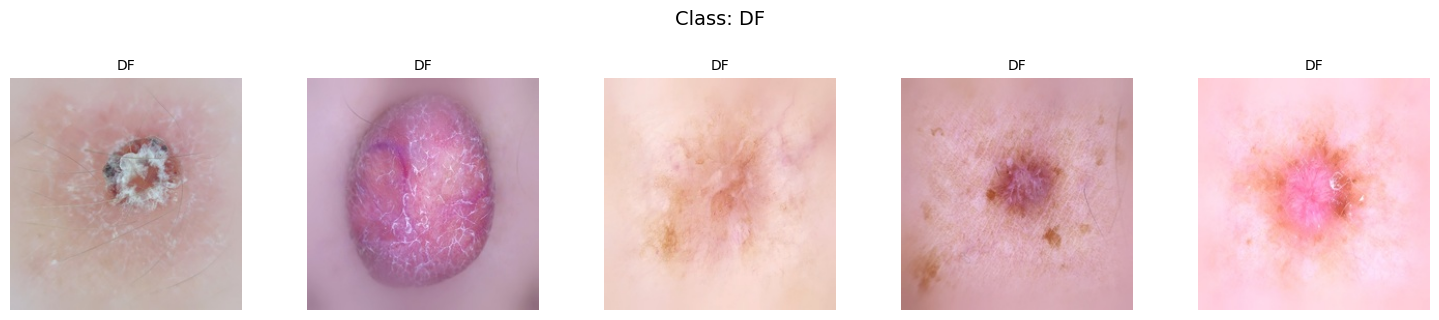

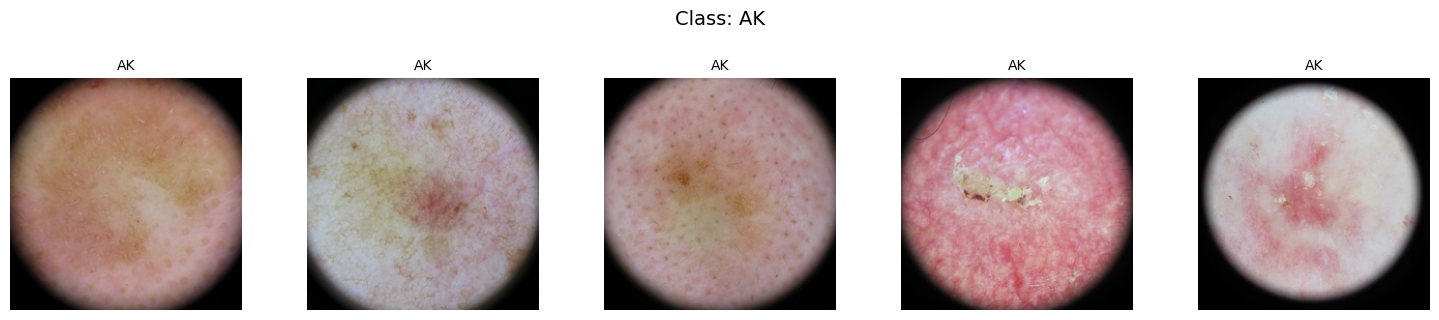

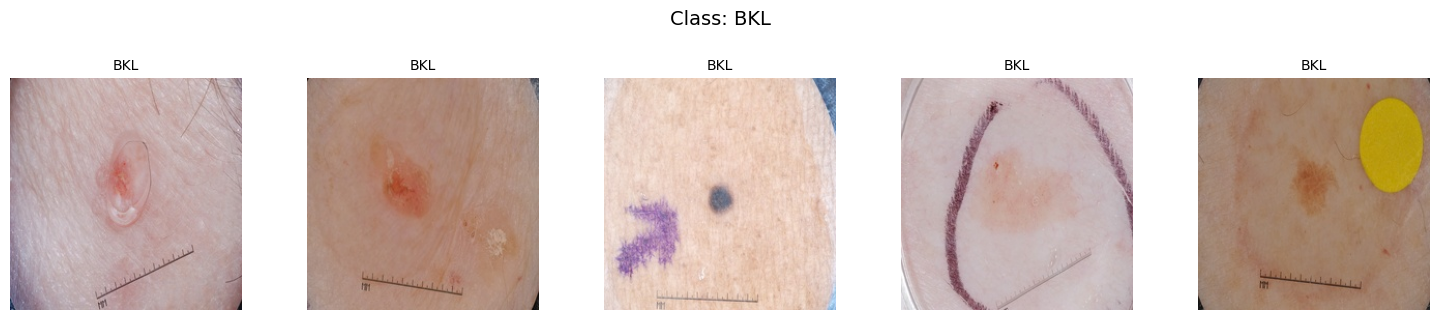

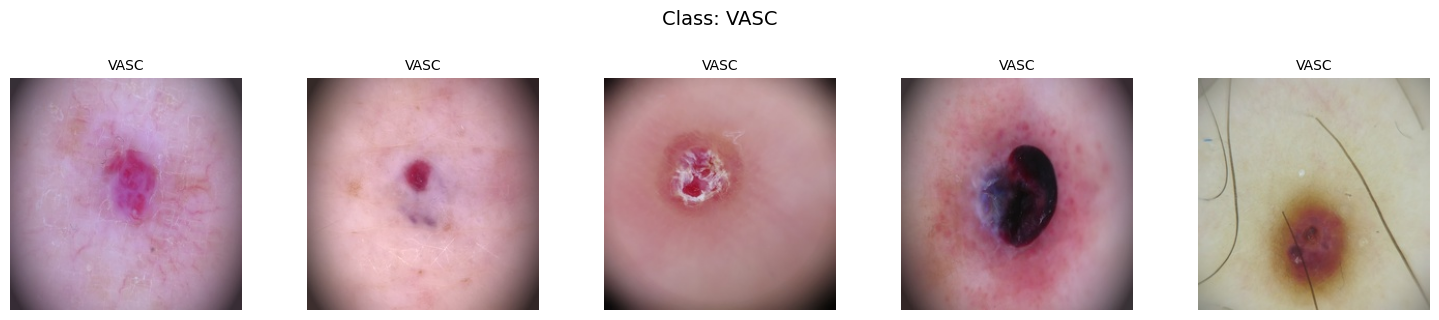

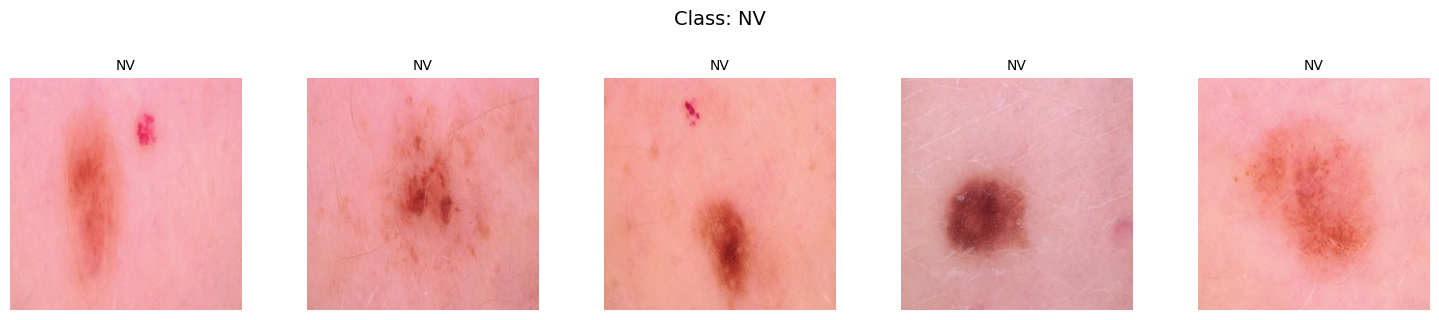

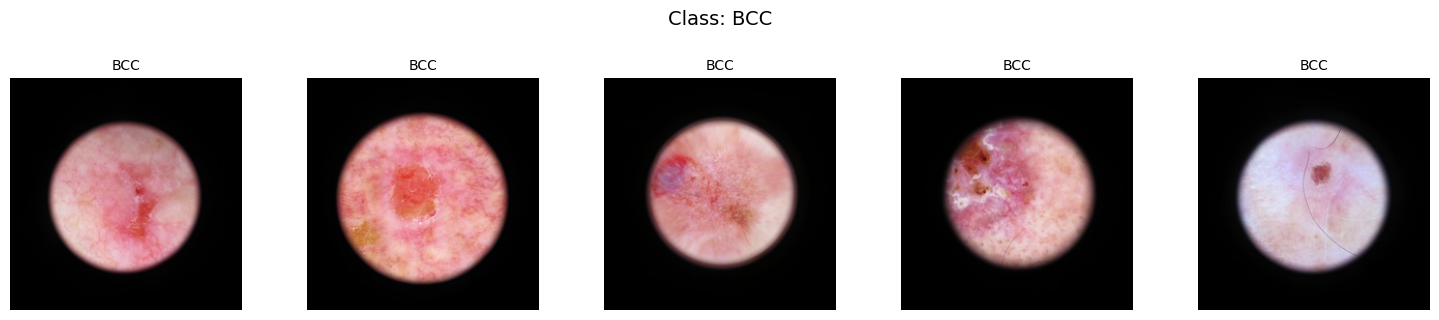

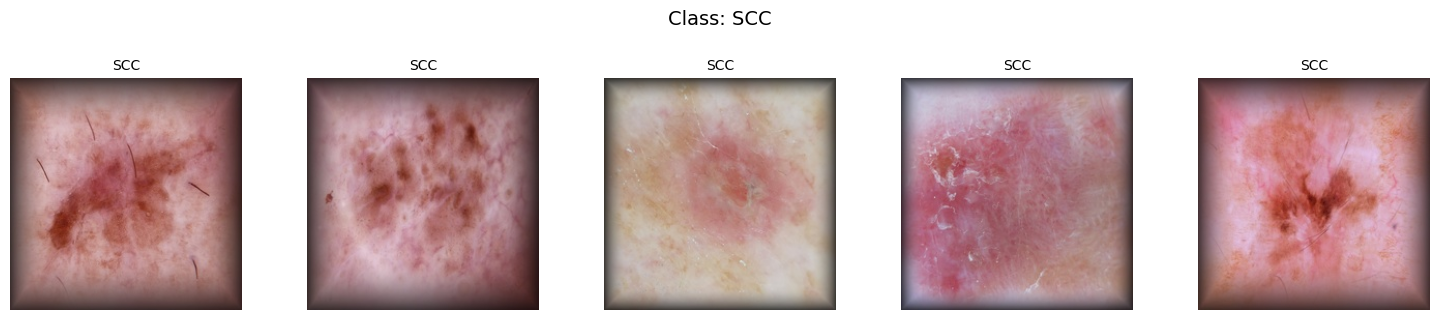

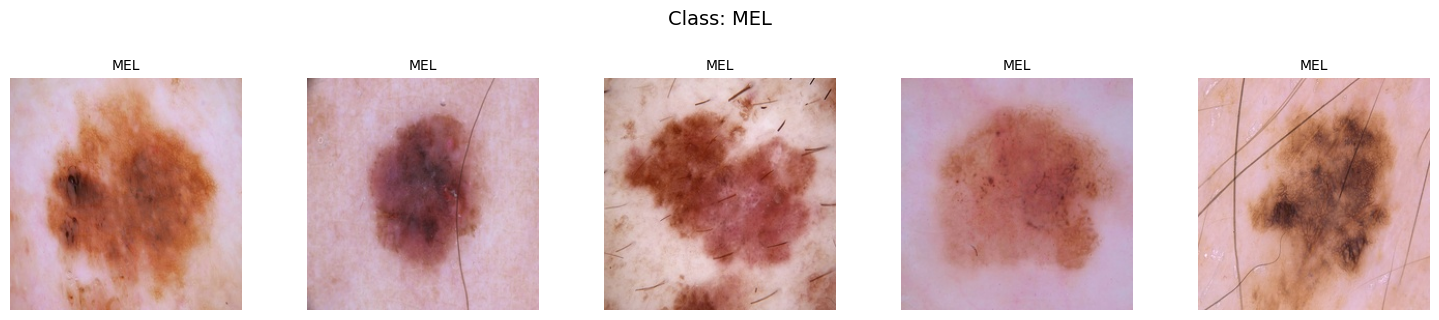

In [9]:
import os
import random
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]

    if len(jpg_files) == 0:
        print(f"⚠️ No JPG images found in '{cls}'")
        continue

    sample_files = random.sample(jpg_files, min(5, len(jpg_files)))

    plt.figure(figsize=(15, 3))
    for i, filename in enumerate(sample_files):
        file_path = os.path.join(folder_path, filename)
        img = Image.open(file_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{cls[:12]}", fontsize=10)

    plt.suptitle(f"Class: {cls}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

In [10]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Skin Leison"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/SkinLeison"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-07 09:06:48.712670: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-07 09:06:48.712699: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-07 09:06:48.712705: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-07 09:06:48.712718: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-07 09:06:48.712728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 1234 validated image filenames belonging to 8 classes.
Found 264 validated image filenames belonging to 8 classes.
Found 265 validat

# MULTI CANCER

## ALL CANCER CELL

In [1]:
import os
from PIL import Image
from tqdm import tqdm

# =========================================================
# Path to your dataset
# =========================================================
base_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/ALL"
target_size = (224, 224)

# =========================================================
# Automatically detect all class folders
# =========================================================
class_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(f"🔍 Found class folders: {class_folders}")

# =========================================================
# Resize all .jpg images in each class folder
# =========================================================
for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    print(f"\n📁 Resizing images in '{cls}' folder...")

    jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]

    for filename in tqdm(jpg_files, desc=f"Processing {cls}", ncols=80):
        file_path = os.path.join(folder_path, filename)
        try:
            with Image.open(file_path).convert("RGB") as img:
                img = img.resize(target_size, Image.LANCZOS)
                img.save(file_path, "JPEG", quality=95)
        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

print("\n✅ All .jpg images resized to 224×224 successfully across all 8 classes!")


🔍 Found class folders: ['all_benign', 'all_pre', 'all_early', 'all_pro']

📁 Resizing images in 'all_benign' folder...


Processing all_benign: 100%|███████████████| 5000/5000 [00:10<00:00, 458.20it/s]



📁 Resizing images in 'all_pre' folder...


Processing all_pre: 100%|██████████████████| 5000/5000 [00:11<00:00, 450.99it/s]



📁 Resizing images in 'all_early' folder...


Processing all_early: 100%|████████████████| 5000/5000 [00:10<00:00, 458.34it/s]



📁 Resizing images in 'all_pro' folder...


Processing all_pro: 100%|██████████████████| 5000/5000 [00:10<00:00, 468.83it/s]


✅ All .jpg images resized to 224×224 successfully across all 8 classes!


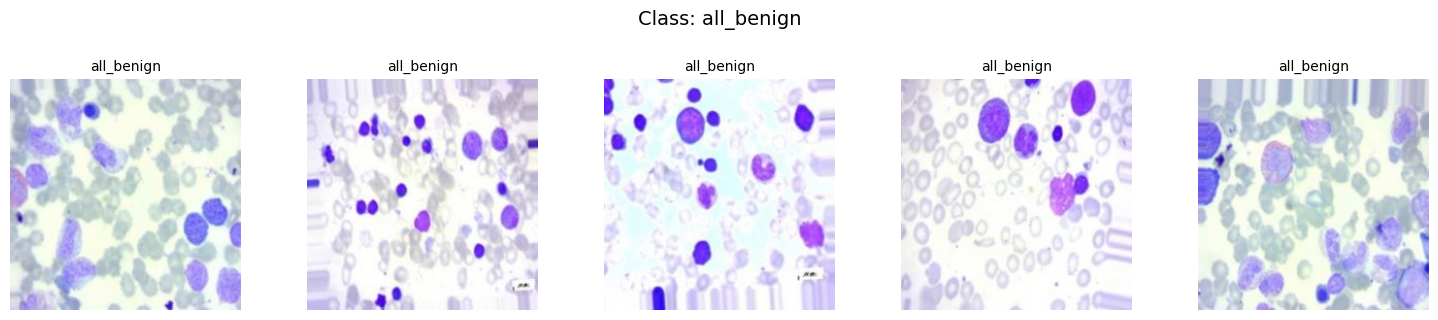

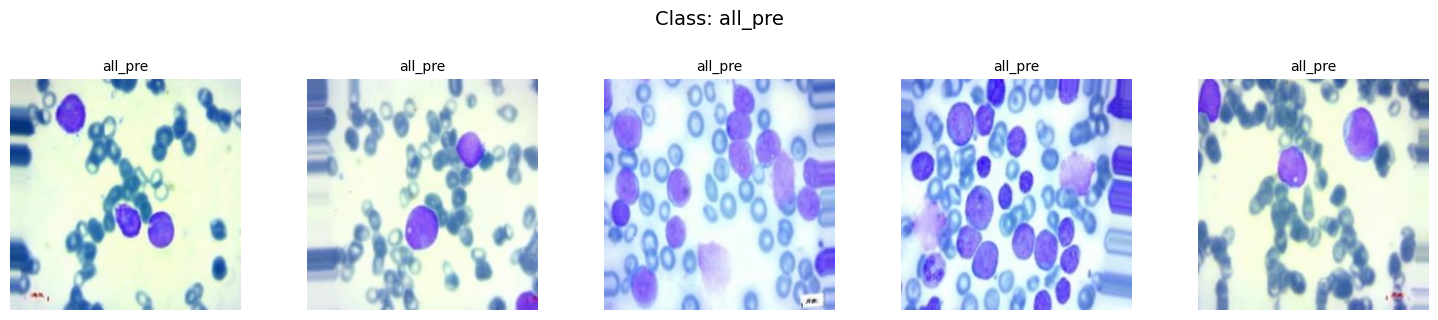

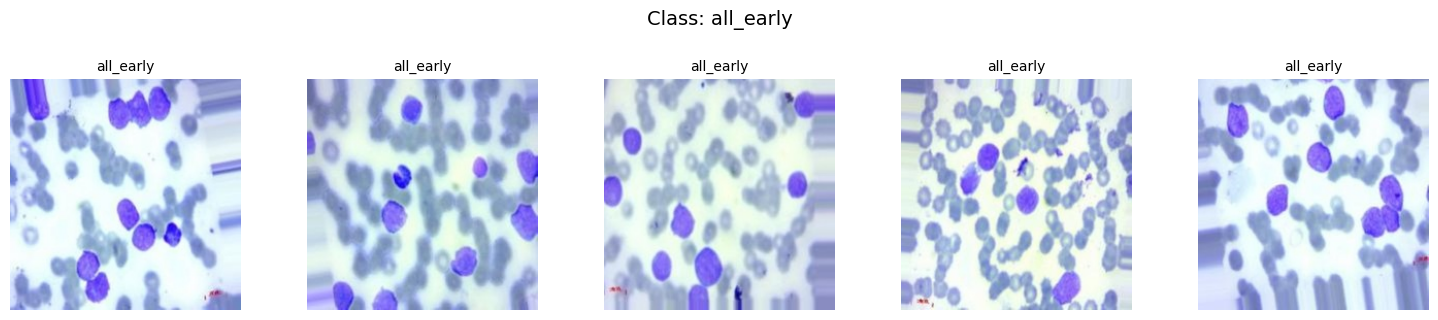

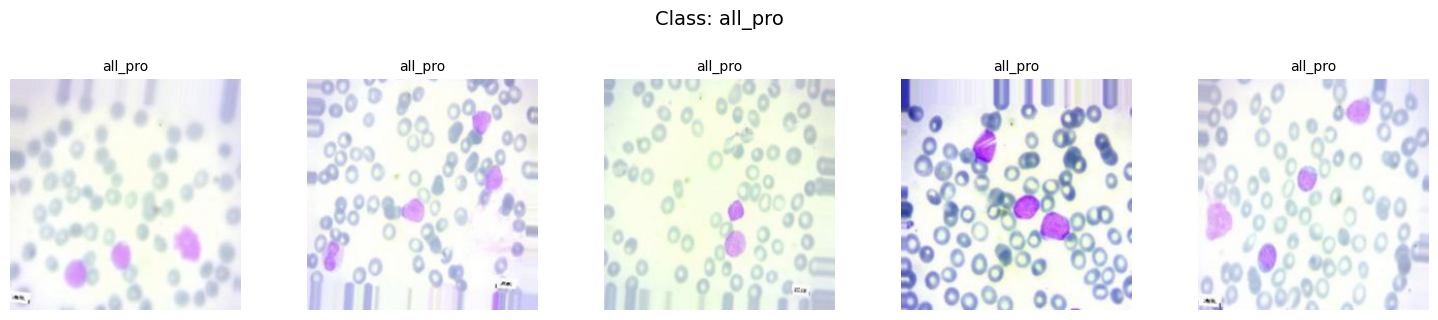

In [2]:
import os
import random
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

for cls in class_folders:
    folder_path = os.path.join(base_path, cls)
    jpg_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]

    if len(jpg_files) == 0:
        print(f"⚠️ No JPG images found in '{cls}'")
        continue

    sample_files = random.sample(jpg_files, min(5, len(jpg_files)))

    plt.figure(figsize=(15, 3))
    for i, filename in enumerate(sample_files):
        file_path = os.path.join(folder_path, filename)
        img = Image.open(file_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{cls[:12]}", fontsize=10)

    plt.suptitle(f"Class: {cls}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

In [4]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/ALL"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/ALL_CANCER"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-07 18:53:41.963042: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-07 18:53:41.963225: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-07 18:53:41.963233: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-07 18:53:41.963586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-07 18:53:41.963600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 14000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.
Found 3000 vali

## Brain Cancer

In [1]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/Brain Cancer"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/Brain_TL"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-09 19:19:15.791293: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-09 19:19:15.791333: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-09 19:19:15.791339: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-09 19:19:15.791368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-09 19:19:15.791378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 10500 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 2250 vali

## Cervical Cancer

In [3]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/Cervical Cancer"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/Cervical_TL"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-09 23:08:26.171979: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-09 23:08:26.172012: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-09 23:08:26.172016: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-09 23:08:26.172030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-09 23:08:26.172041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 vali

## Kideny Cancer

In [4]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/Kidney Cancer"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/Kidney_TL"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-10 03:38:42.622884: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-10 03:38:42.622924: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-10 03:38:42.622929: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-10 03:38:42.622945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-10 03:38:42.622956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 7000 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 1500 valid

## Lymphoma Cancer

In [6]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/Lymphoma"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/Lymphoma_TL"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-10 09:29:21.256407: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-10 09:29:21.256442: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-10 09:29:21.256446: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-10 09:29:21.256460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-10 09:29:21.256471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 10500 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 2250 vali

## Oral Cancer

In [7]:
import subprocess

script_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/run_training.py"
dataset_path = "/Volumes/Sarbajit/Model Optimization/Data/Multi Cancer/Multi Cancer/Oral Cancer"
output_path = "/Volumes/Sarbajit/Model Optimization/Transfer Learning Model/Output/oral_TL"

process = subprocess.Popen(
    ["python3", script_path, "--data_dir", dataset_path, "--output_dir", output_path],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

for line in process.stdout:
    print(line, end="")

process.wait()
print(f"\n✅ Training finished with exit code {process.returncode}")


🚀 Training started for model: efficientnetv2b3
2025-10-10 11:23:33.683488: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-10-10 11:23:33.683522: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-10 11:23:33.683527: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-10 11:23:33.683541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-10 11:23:33.683551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Found 7001 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 1501 valid

## All Raw Data Download

In [2]:
%pip install -q kagglehub

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import kagglehub
import shutil

# 🔹 Target base directory
BASE_DIR = "/Volumes/Sarbajit/Model Optimization/Data/Raw_Data"

# 🔹 Create base directory if it doesn’t exist
os.makedirs(BASE_DIR, exist_ok=True)

# 🔹 List of all datasets with KaggleHub slugs and folder names
datasets = {
    "mehradaria/leukemia": "Leukemia",
    "anaselmasry/breast-cancer-dataset": "Breast Cancer",
    "prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed": "Cervical Cancer",
    "nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone": "Kidney Cancer",
    "biplobdey/lung-and-colon-cancer": "Lung and Colon Cancer",
    "andrewmvd/malignant-lymphoma-classification": "Lymphoma",
    "ashenafifasilkebede/dataset": "Oral Cancer",
}

# 🔹 Figshare Brain Tumor dataset (no KaggleHub slug)
# You can download it manually or via direct link if needed
brain_dataset_url = "https://figshare.com/articles/dataset/brain_tumor_dataset/1512427"
brain_dataset_name = "Brain Cancer"

# 🔹 Download Kaggle datasets
for kaggle_slug, folder_name in datasets.items():
    print(f"\n📦 Downloading {folder_name} dataset from Kaggle...")
    try:
        dataset_path = kagglehub.dataset_download(kaggle_slug)
        target_dir = os.path.join(BASE_DIR, folder_name)
        os.makedirs(target_dir, exist_ok=True)
        
        # Copy downloaded files to organized target directory
        for item in os.listdir(dataset_path):
            src_path = os.path.join(dataset_path, item)
            dst_path = os.path.join(target_dir, item)
            if os.path.isdir(src_path):
                shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
            else:
                shutil.copy2(src_path, dst_path)
                
        print(f"✅ {folder_name} dataset saved at: {target_dir}")
    except Exception as e:
        print(f"❌ Failed to download {folder_name}: {e}")

# 🔹 Add Brain Cancer dataset info for manual download
print(f"\n⚠️ The Brain Cancer dataset is hosted on Figshare.")
print(f"🔗 Download manually from: {brain_dataset_url}")
print(f"📁 After download, place it in: {os.path.join(BASE_DIR, brain_dataset_name)}")

print("\n🎯 All available Kaggle datasets have been downloaded successfully!")


/opt/anaconda3/envs/transformers_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📦 Downloading Leukemia dataset from Kaggle...


100%|██████████| 110M/110M [00:36<00:00, 3.16MB/s] 

Extracting files...


✅ Leukemia dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Leukemia

📦 Downloading Breast Cancer dataset from Kaggle...


100%|██████████| 3.93G/3.93G [21:50<00:00, 3.22MB/s]  

Extracting files...


✅ Breast Cancer dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Breast Cancer

📦 Downloading Cervical Cancer dataset from Kaggle...


100%|██████████| 6.40G/6.40G [50:42<00:00, 2.26MB/s]  

Extracting files...


✅ Cervical Cancer dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Cervical Cancer

📦 Downloading Kidney Cancer dataset from Kaggle...


100%|██████████| 1.52G/1.52G [07:53<00:00, 3.44MB/s]

Extracting files...


✅ Kidney Cancer dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Kidney Cancer

📦 Downloading Lung and Colon Cancer dataset from Kaggle...


100%|██████████| 1.76G/1.76G [09:05<00:00, 3.46MB/s]

Extracting files...


✅ Lung and Colon Cancer dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Lung and Colon Cancer

📦 Downloading Lymphoma dataset from Kaggle...


100%|██████████| 1.34G/1.34G [06:35<00:00, 3.65MB/s]

Extracting files...


✅ Lymphoma dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Lymphoma

📦 Downloading Oral Cancer dataset from Kaggle...


100%|██████████| 2.93G/2.93G [14:42<00:00, 3.57MB/s] 

Extracting files...


✅ Oral Cancer dataset saved at: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Oral Cancer

⚠️ The Brain Cancer dataset is hosted on Figshare.
🔗 Download manually from: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427
📁 After download, place it in: /Volumes/Sarbajit/Model Optimization/Data/Raw_Data/Brain Cancer

🎯 All available Kaggle datasets have been downloaded successfully!
